In [1]:
import matplotlib.pyplot as plt
import matplotlib
import wandb
from rliable import library as rly
from rliable import metrics
from matplotlib.patches import Patch
from rliable import plot_utils
import seaborn as sns
import numpy as np
import os
from collections import OrderedDict

from utils import *

In [2]:
# plt.rcParams["legend.title_fontsize"] = "large"
plt.rcParams.update({'font.size': 20})

matplotlib.rc("xtick", labelsize=20)
matplotlib.rc("ytick", labelsize=20)

In [3]:
# Initialize the wandb API
api = wandb.Api()

# Define your project and entity (replace with your specific values)
entity = "cl-probing"  # e.g., your username or team name
figures_path = "./figures"
data_path = "./data"
os.makedirs(figures_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
take_x_seeds = 10
window_size = 10
use_se = True
all_configs = []

## Generalized Stitching Configs

In [4]:
def exact_grouping_func(config):
    result = ''
    if config['agent']['agent_name'] == 'gcdqn':
        result += 'GCDQN'
    elif config['agent']['agent_name'] == 'clearn_search':
        result += "C-LEARN"
    else:
        result += "CRL"

    result += '_' + str(config['env']['number_of_boxes_max'])

    return result

def generalized_grouping_func(config):
    result = ''
    if config['agent']['agent_name'] == 'gcdqn':
        result += 'GCDQN'
    elif config['agent']['agent_name'] == 'clearn_search':
        result += "C-LEARN"
    else:
        result += "CRL"

    result += '_' + str(config['env']['number_of_moving_boxes_max'])

    return result

agents = ['GCDQN', 'C-LEARN', 'CRL']

config_1 = {
    "directory": "main",
    "save":"main_exact_stitching",
    "title": f"Exact Stitching",
    "projects":["paper_main_fig_exact"],
    "possible_names":['_'.join([agent, s]) for agent in agents for s in [str(i) for i in range(1, 5)]],
    "filters":{
        "state":"finished",
    },
    "grouping_func": exact_grouping_func,
    "metrics": OrderedDict([
        ("eval/mean_success", "Training success on 3 boxes \n(1 on target)"), 
        ("eval_special/mean_success", "Test success on 3 boxes \n(0 on target)"),
    ]),
    "ylabel": 'Number of boxes',
}

config_2 = {
    "directory": "main",
    "save": "main_generalized_stitching",
    "title": f"Generalized Stitching",
    "projects":["paper_main_fig_generalized"],
    "possible_names":['_'.join([agent, s]) for agent in agents for s in [str(i) for i in range(1, 5)]],
    "filters":{
        "state":"finished",
    },
    "grouping_func": generalized_grouping_func,
    "metrics": OrderedDict([
        ("eval/mean_success", "Training success on 3 boxes \n(1 on target)"), 
        ("eval_4/mean_success", "Test success on 3 boxes \n(0 on target)"),
    ]),
    "ylabel": 'Number of boxes starting on target (always 4 boxes in total)',
}

all_configs.append(config_1)
all_configs.append(config_2)


# Plotting

dict_keys(['GCDQN_1_test', 'GCDQN_1_train', 'GCDQN_2_test', 'GCDQN_2_train', 'GCDQN_3_test', 'GCDQN_3_train', 'GCDQN_4_test', 'GCDQN_4_train', 'C-LEARN_1_test', 'C-LEARN_1_train', 'C-LEARN_2_test', 'C-LEARN_2_train', 'C-LEARN_3_test', 'C-LEARN_3_train', 'C-LEARN_4_test', 'C-LEARN_4_train', 'CRL_1_test', 'CRL_1_train', 'CRL_2_test', 'CRL_2_train', 'CRL_3_test', 'CRL_3_train', 'CRL_4_test', 'CRL_4_train'])
dict_keys(['GCDQN_1_test', 'GCDQN_1_train', 'GCDQN_2_test', 'GCDQN_2_train', 'GCDQN_3_test', 'GCDQN_3_train', 'GCDQN_4_test', 'GCDQN_4_train', 'C-LEARN_1_test', 'C-LEARN_1_train', 'C-LEARN_2_test', 'C-LEARN_2_train', 'C-LEARN_3_test', 'C-LEARN_3_train', 'C-LEARN_4_test', 'C-LEARN_4_train', 'CRL_1_test', 'CRL_1_train', 'CRL_2_test', 'CRL_2_train', 'CRL_3_test', 'CRL_3_train', 'CRL_4_test', 'CRL_4_train'])
dict_keys(['GCDQN_1_test', 'GCDQN_1_train', 'GCDQN_2_test', 'GCDQN_2_train', 'GCDQN_3_test', 'GCDQN_3_train', 'GCDQN_4_test', 'GCDQN_4_train', 'C-LEARN_1_test', 'C-LEARN_1_train', 'C-L

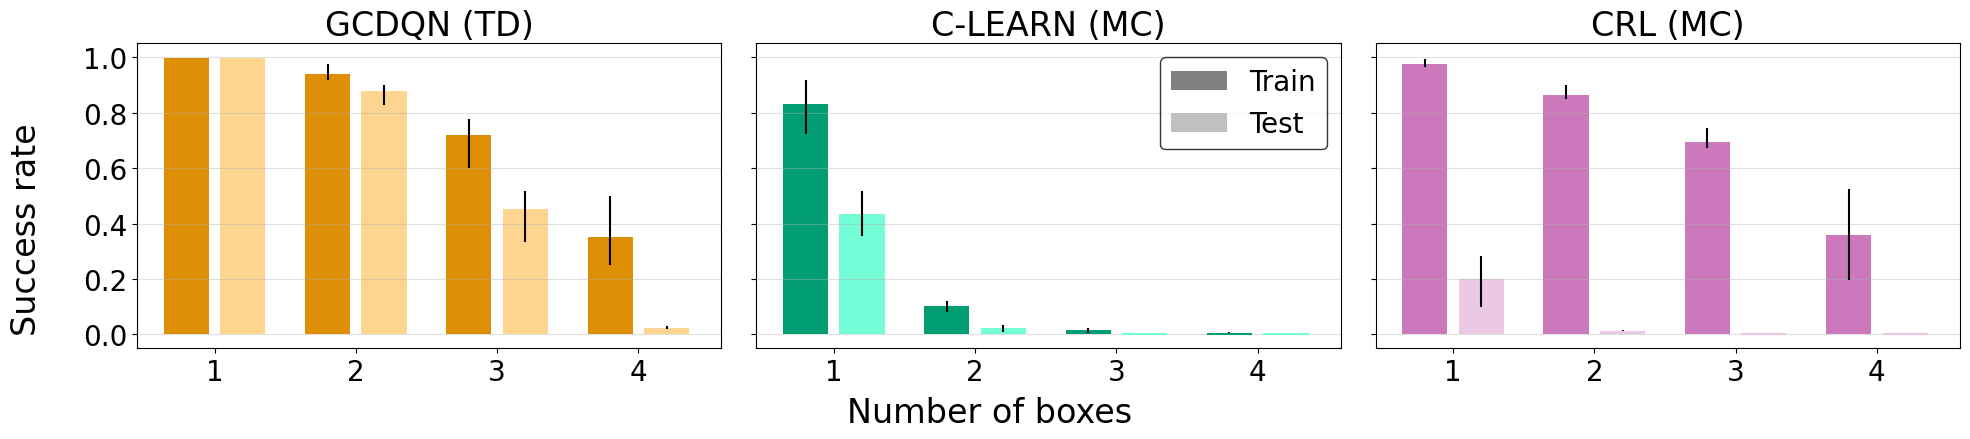

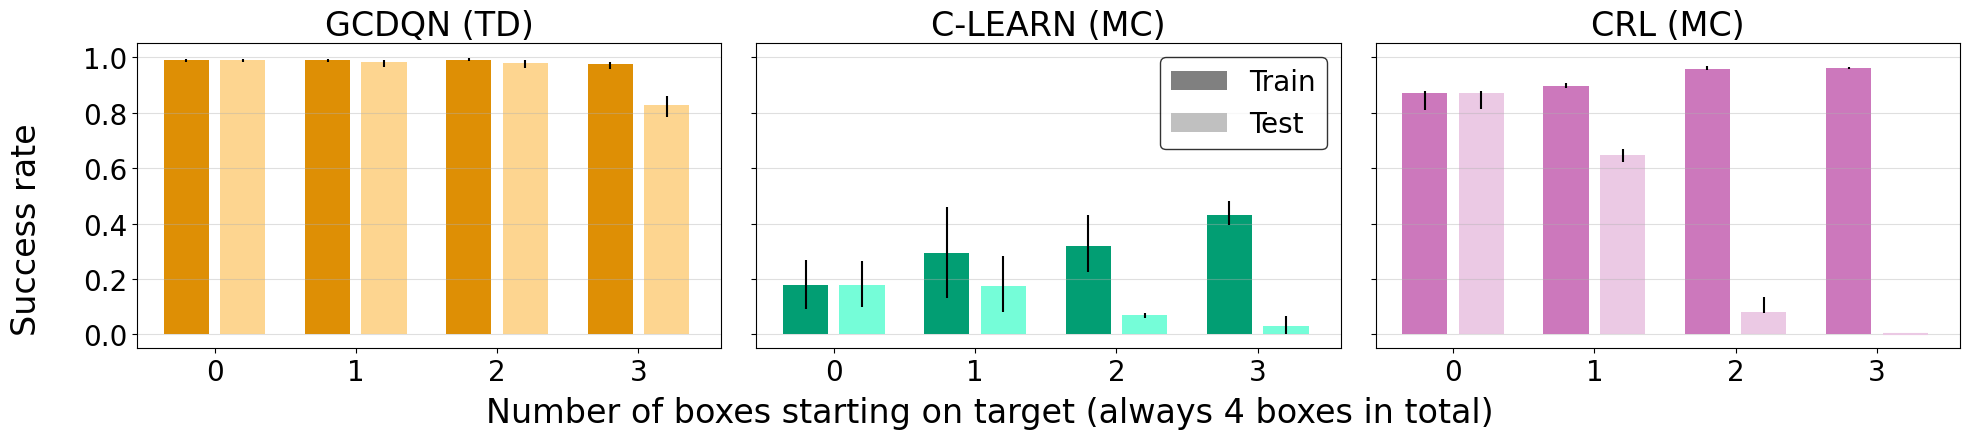

In [5]:



# axes[0, 0].set_ylabel('Exact stitching')
# axes[1, 0].set_ylabel('Generalized stitching')
# axes[0,1].set_xlabel('Number of boxes (none start on targets)')
# axes[1,1].set_xlabel('Number of boxes starting not on targets (always 4 boxes in total)')


for config_idx, config in enumerate(all_configs):
    fig, axes = plt.subplots(1, 3, figsize=(20,5), sharey='row')
    plt.title(config['title'])
    fig.supylabel('Success rate', x=0.01)
    fig.supxlabel(config['ylabel'], y=0.1)
    runs = []
    for project in config['projects']:
        project_runs = api.runs(path=f"{entity}/{project}", filters=config['filters'])
        runs.extend([r for r in project_runs])

    data = aggregate_data_from_wandb(runs, config['metrics'], config['possible_names'], config['grouping_func'], return_last_step=True)
    data_curves = aggregate_data_from_wandb(runs, config['metrics'], config['possible_names'], config['grouping_func'], return_last_step=False)


    empty_keys = []
    for k, v in data_curves.items():
        if v.size == 0:
            empty_keys.append(k)

    for k in empty_keys:
        del data_curves[k]

    new_data = OrderedDict()

    for k, v in data_curves.items():
        aggregated_v = np.mean(v[:, -5:, :], axis=1)
        new_data[k + '_test'] = aggregated_v[:, 1].reshape(-1, 1)
        new_data[k + '_train'] = aggregated_v[:, 0].reshape(-1, 1)

    names = list(new_data.keys())

    metrics_names = config['metrics']

    figure_path = os.path.join(figures_path, config['directory'])
    os.makedirs(figure_path, exist_ok=True)

    aggregate_func = lambda x: np.array([metrics.aggregate_iqm(x[:, i]) for i in range(x.shape[-1])])

    aggregate_scores, aggregate_scores_cis = rly.get_interval_estimates(
        new_data, aggregate_func, reps=500
    )




    for ax, alg in zip(axes, agents):

        ax.set_title(alg + (" (TD)" if alg == "GCDQN" else " (MC)"))
        ax.grid(alpha=0.4, axis='y')
        ax.set_ylim(bottom=-0.05, top=1.05)
        box_centers = []

        box_labels = []
        for box_num in range(4):
            box_center = 2.5 * box_num + 0.5
            box_centers.append(box_center)
            # ax.axvspan(box_center - 1, box_center, color='palegreen', alpha=0.25)
            ax.axvspan(box_center, box_center + 1, color='white', alpha=1.0, hatch='/')

            print(aggregate_scores.keys())

            if config_idx == 0:
                box_lookup_label = str(box_num + 1)
                box_labels.append(box_lookup_label)
            else:
                box_lookup_label = str(4 - box_num)
                box_labels.append(str(box_num))
            train_score = aggregate_scores['_'.join([alg, box_lookup_label, 'train'])]
            test_score = aggregate_scores['_'.join([alg, box_lookup_label, 'test'])]
            # ax.hlines(train_score, xmin=box_center - 1, xmax=box_center, color='black')
            # ax.hlines(,  xmin=box_center, xmax=box_center+1, color='black')

            train_bottom = aggregate_scores_cis['_'.join([alg, box_lookup_label, 'train'])][0]
            train_top = aggregate_scores_cis['_'.join([alg, box_lookup_label, 'train'])][1]

            test_bottom = aggregate_scores_cis['_'.join([alg, box_lookup_label, 'test'])][0]
            test_top = aggregate_scores_cis['_'.join([alg, box_lookup_label, 'test'])][1]

            alg_id = alg + ('_TD' if 'DQN' in alg else '_MC')
            train_color=return_color(alg_id, train=True)
            test_color=return_color(alg_id, train=False)
            ax.bar(box_center - 0.5, train_score, yerr=(train_score - train_bottom, train_top - train_score), color=train_color)
            ax.bar(box_center + 0.5, test_score, yerr=(test_score - test_bottom, test_top - test_score), color=test_color)

            if train_score <= 0.01:
                ax.hlines(train_score, xmin=box_center - 0.9, xmax=box_center - 0.1, color=train_color)

            if test_score <= 0.01:
                ax.hlines(test_score, xmin=box_center+0.1, xmax=box_center+0.9, color=test_color)


        ax.set_xticks(np.array(box_centers), box_labels)
        ax.set_yticks(np.arange(0, 1.1, 0.2))


    legend_train_color = 'gray'
    legend_test_color = lighten_color('gray', amount=0.5)
    legend_elements = [Patch(facecolor=legend_train_color, label='Train'), Patch(facecolor=legend_test_color, label='Test')]

    axes[1].legend(handles=legend_elements, edgecolor='black', loc='upper right')

    plt.tight_layout()


    plt.savefig(os.path.join(figure_path, config['save']) + '.png',bbox_inches='tight')
    plt.savefig(os.path.join(figure_path, config['save']) + '.pdf',bbox_inches='tight')
